# Compare different shift fit models

Different time periods and with/without scale also shifting

In [1]:
# necessary: netcdf4-python, regionmask, (xarray, geopandas), cartopy, openpyxl, statsmodels

import numpy as np
import pandas as pd
import os, glob, re 
import math
import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import dask
import matplotlib.pyplot as plt
import netCDF4

%matplotlib inline

#plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from scipy.stats import norm

# import my variables settings functions from other scripts
from settings_ana import *

# import fxns 
from functions_ana import *
from utils_ana import *
from plotscript import *

# import other packages/modules 

sys.path.append('../population/') # make this a module i can pip install and import ! 
from population_demographics_climate import * # move / rename this when good ! --> change to import demographics4climate as d4c

sys.path.append('../dist_cov/dist_cov/')
import distributions as distributions
#import sample as sample
#import utils as utils 

In [2]:
start_message() # change indir to indir obs and datasets to datasets obs in start message

flags: {'models': 'ISIMIP3b', 'experiment': None, 'metric': 'WBGT28', 'method': None, 'time_method': None, 'shift_sigma': False, 'shift_period': None, 'shift_loglike': None, 'chunk_version': None, 'var': 'wbgt'}
var: wbgt
VARs: None
indir_p: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/InputData/climate/atmosphere/bias-adjusted/global/daily/
indir_s: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/
indir_obs: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/obsclim/global/daily/historical/
indir_counterclim: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/counterclim/global/daily/historical/
GCMs: ['CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0']
datasets: ['GSWP3-W5E5', '20CRv3-ERA5', '20CRv3-W5E5']
lat_chunk: 90
lon_chunk: 120
time_chunk: -1
outdirs: /data/brussel/vo/000/bvo00012/vsc10419/

In [3]:
from dask.distributed import Client 
client = Client()
client

<Client: 'tcp://127.0.0.1:40969' processes=2 threads=2, memory=60.00 GiB>

In [4]:


def calc_nAHD_shift_fit(da_params, threshold, gmst_smo,year_pres=2022,GWI=1.3):

    gmst_pres = float(gmst_smo.loc[year_pres]) # take smoothed or not smoothed covariate ?? 
    gmst_pi = float(gmst_pres - GWI)

    b0 = da_params.sel(params='b0')
    b1 = da_params.sel(params='b1')


    if len(da_params.params) >3:
        sigma_b0 = da_params.sel(params='sigma_b0')
        sigma_b1 = da_params.sel(params='sigma_b1')
        norm_pi, norm_pres = norm(loc=b0+b1*gmst_pi, scale=sigma_b0+sigma_b1*gmst_pi), norm(loc=b0+b1*gmst_pres, scale=sigma_b0+sigma_b1*gmst_pres)
    elif len(da_params.params) ==3:
        sigma_b0 = da_params.sel(params='sigma')
        norm_pi, norm_pres = norm(loc=b0+b1*gmst_pi, scale=sigma_b0), norm(loc=b0+b1*gmst_pres, scale=sigma_b0)

    data = norm_pres.sf(threshold)
    da_p1 = xr.DataArray(
        data=data,
        dims=["dataset", "month", "lat", "lon", ],
        coords=dict(
            lon=(["lon"], da_params.lon.data),
            lat=(["lat"], da_params.lat.data),
            month=da_params.month.data,
            dataset=da_params.dataset.data) )
    
    data = norm_pi.sf(threshold)
    da_p0 = xr.DataArray(
        data=data,
        dims=[ "dataset", "month", "lat", "lon"],
        coords=dict(
            lon=(["lon"], da_params.lon.data),
            lat=(["lat"], da_params.lat.data),
            month=da_params.month.data,
            dataset=da_params.dataset.data) )
    
    da_nAHD_mo = (da_p1 - da_p0) * 30.5 # TODO: change with actual length of each month
    
    da_nAHD = da_nAHD_mo.sum(dim='month')


    return da_nAHD, da_nAHD_mo, da_p0, da_p1

# Fit to models

In [5]:
flags['models']='ISIMIP3a'
dirname = 'output_shift-fit' 

da_list = []

for i in range(len(datasets)):
    dataset = datasets[i]
    filepath = glob.glob(os.path.join('/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output', 
                                      f'output_shift-fit/forster2024/WBGT/ISIMIP3a/{dataset}/*_obsclim_WBGT_params_shift_loc_sigma_mon_1901_2019.nc'))[0]
    da = xr.open_dataarray(filepath).expand_dims("dataset").assign_coords(dataset=("dataset", [dataset]))
    da_list.append(da)
    
    da_params_lsl = xr.concat(da_list, dim="dataset") #loc sigma long


da_list = []

for i in range(len(datasets)):
    dataset = datasets[i]
    filepath = glob.glob(os.path.join('/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output', 
                                      f'output_shift-fit/forster2024/WBGT/ISIMIP3a/{dataset}/*_obsclim_WBGT_params_shift_loc_sigma_mon_1950_2019.nc'))[0]
    da = xr.open_dataarray(filepath).expand_dims("dataset").assign_coords(dataset=("dataset", [dataset]))
    da_list.append(da)
    
    da_params_lss = xr.concat(da_list, dim="dataset") #loc sigma short



# once i have for other datasets also ! 

da_list = []

for i in range(len(datasets)):
    dataset = datasets[i]
    filepath = glob.glob(os.path.join('/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output', 
                                      f'output_shift-fit/forster2024/WBGT/ISIMIP3a/{dataset}/*_obsclim_WBGT_params_shift_loc_mon_loglike_1901_2019.nc'))[0] # rename, these dont have loglike info !! 
    da = xr.open_dataarray(filepath).expand_dims("dataset").assign_coords(dataset=("dataset", [dataset]))
    da_list.append(da)
    
    da_params_ll = xr.concat(da_list, dim="dataset") #loc long


da_list = []


for i in range(len(datasets)):
    dataset = datasets[i]
    filepath = glob.glob(os.path.join('/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output', 
                                      f'output_shift-fit/forster2024/WBGT/ISIMIP3a/{dataset}/*_obsclim_WBGT_params_shift_loc_mon_loglike_1950_2019.nc'))[0]
    da = xr.open_dataarray(filepath).expand_dims("dataset").assign_coords(dataset=("dataset", [dataset]))
    da_list.append(da)
    da_params_ls = xr.concat(da_list, dim="dataset") #loc long


In [6]:
df_gmst_obs_annual = pd.read_csv(os.path.join('../../data/gmst/gmst-obs/forster2024/annual_averages.csv')).rename(
    columns={'timebound_lower':'year'}).set_index('year')[['gmst']]
gmst_smo = pd.DataFrame(apply_lowess(df_gmst_obs_annual, df_gmst_obs_annual.index, ntime=4))
#gmst_smo

In [7]:
threshold = 28
year_pres = 2022 # for covariate fit

from scipy.stats import norm


In [8]:
da_params_lss

<xarray.DataArray 'fit_params' (dataset: 3, month: 12, lat: 360, lon: 720,
                                params: 4)>
array([[[[[-3.16018020e+01,  7.96069081e+00,  7.01282047e+00,
           -5.26559556e-01],
          [-3.16028923e+01,  7.96018003e+00,  7.01234799e+00,
           -5.25954604e-01],
          [-3.16038197e+01,  7.95951250e+00,  7.01199226e+00,
           -5.25456619e-01],
          ...,
          [-3.15403753e+01,  7.90884377e+00,  6.78456342e+00,
           -2.72914506e-01],
          [-3.15415259e+01,  7.90826973e+00,  6.78399525e+00,
           -2.72219600e-01],
          [-3.15626890e+01,  7.92529128e+00,  6.88615248e+00,
           -3.86327684e-01]],

         [[-3.18863156e+01,  8.18759138e+00,  7.10523044e+00,
           -8.17899932e-01],
          [-3.18905427e+01,  8.18630101e+00,  7.10460277e+00,
           -8.17366751e-01],
          [-3.18955082e+01,  8.18561313e+00,  7.10358686e+00,
           -8.16248934e-01],
...
          [-1.33036757e+01,  1.97811759e+00,  2.41502384e+00,
            4.81613799e-02],
          [-1.32997877e+01,  1.97908003e+00,  2.41542624e+00,
            4.68592712e-02],
          [-1.32959701e+01,  1.97879857e+00,  2.41564567e+00,
            4.56829559e-02]],

         [[-1.35504747e+01,  2.21833998e+00,  2.49014100e+00,
           -3.72037582e-02],
          [-1.35505551e+01,  2.21892701e+00,  2.48980527e+00,
           -3.70597598e-02],
          [-1.35501047e+01,  2.22011659e+00,  2.48937157e+00,
           -3.63931357e-02],
          ...,
          [-1.35508146e+01,  2.21579224e+00,  2.49187110e+00,
           -3.87343771e-02],
          [-1.35513188e+01,  2.21752462e+00,  2.49105070e+00,
           -3.79159515e-02],
          [-1.35513146e+01,  2.21809027e+00,  2.49040908e+00,
           -3.74505696e-02]]]]])
Coordinates:
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * params   (params) object 'b0' 'b1' 'sigma_b0' 'sigma_b1'
  * dataset  (dataset) <U11 'GSWP3-W5E5' '20CRv3-ERA5' '20CRv3-W5E5'

In [9]:
da_nAHD_obs_lss, da_nAHD_mo_lss, da_p0_lss, da_p1_lss = calc_nAHD_shift_fit(da_params_lss, threshold, gmst_smo,year_pres=year_pres,GWI=1.3)
da_nAHD_obs_lsl, da_nAHD_mo_lsl, da_p0_lsl, da_p1_lsl = calc_nAHD_shift_fit(da_params_lsl, threshold, gmst_smo,year_pres=year_pres,GWI=1.3)

# lss = loc sigma short
# lsl = loc sigma long

/tmp/ipykernel_3202088/2839177511.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  gmst_pres = float(gmst_smo.loc[year_pres]) # take smoothed or not smoothed covariate ??
/tmp/ipykernel_3202088/2839177511.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  gmst_pres = float(gmst_smo.loc[year_pres]) # take smoothed or not smoothed covariate ??


In [10]:
da_nAHD_obs_ll, da_nAHD_mo_ll, da_p0_ll, da_p1_ll = calc_nAHD_shift_fit(da_params_ll, threshold, gmst_smo,year_pres=year_pres,GWI=1.3)
da_nAHD_obs_ls, da_nAHD_mo_ls, da_p0_ls, da_p1_ls = calc_nAHD_shift_fit(da_params_ls, threshold, gmst_smo,year_pres=year_pres,GWI=1.3)

# ll = loc long
# ls = loc short 

/tmp/ipykernel_3202088/2839177511.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  gmst_pres = float(gmst_smo.loc[year_pres]) # take smoothed or not smoothed covariate ??
/tmp/ipykernel_3202088/2839177511.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  gmst_pres = float(gmst_smo.loc[year_pres]) # take smoothed or not smoothed covariate ??


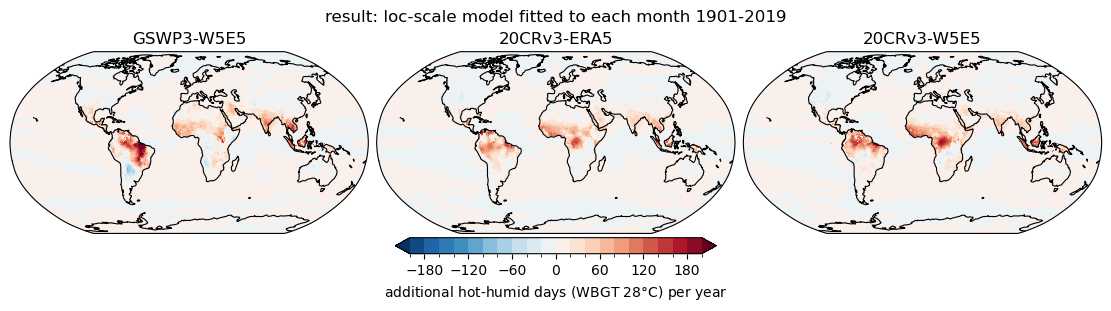

In [11]:
da = da_nAHD_obs_lsl

proj = ccrs.Robinson()
crs = ccrs.PlateCarree()

# make figure object
fig, axes = plt.subplots(1,3, figsize=(11,3), subplot_kw={'projection': proj},  layout='constrained')

vmax = 200

for i in range(3):
    data_plot = da.isel(dataset=i) 
    ax=axes[i]
    plot = data_plot.plot( vmax=vmax, vmin=-vmax, cmap='RdBu_r', transform=crs, levels=21, extend='both', add_colorbar=False, ax=ax)
    ax.coastlines(color='black', linewidth=0.8)
    #ax.set_facecolor('#f0f0f0')
    ax.set_title(f'{data_plot.dataset.values}');
    
cbar_lab = 'additional hot-humid days (WBGT 28$\degree$C) per year' # try to get TeX interpreter 'less likely $\leftarrow$ PR $\rightarrow$ more likely' #'PR' # add more/less likely arrow 
cbar = fig.colorbar(plot,  extend='both', ax=axes,  location='bottom',shrink=1.5,fraction= 0.08,  pad= 0.02) #, fraction= 0.045, pad= 0.04) #location='bottom' 
cbar.set_label(label=cbar_lab) 
    
fig.suptitle('result: loc-scale model fitted to each month 1901-2019');



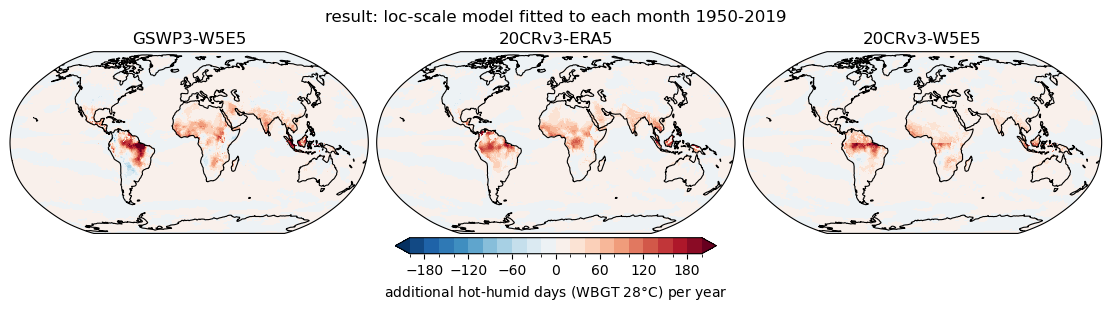

In [12]:
da = da_nAHD_obs_lss

proj = ccrs.Robinson()
crs = ccrs.PlateCarree()

# make figure object
fig, axes = plt.subplots(1,3, figsize=(11,3), subplot_kw={'projection': proj},  layout='constrained')

vmax = 200

for i in range(3):
    data_plot = da.isel(dataset=i) 
    ax=axes[i]
    plot = data_plot.plot( vmax=vmax, vmin=-vmax, cmap='RdBu_r', transform=crs, levels=21, extend='both', add_colorbar=False, ax=ax)
    ax.coastlines(color='black', linewidth=0.8)
    #ax.set_facecolor('#f0f0f0')
    ax.set_title(f'{data_plot.dataset.values}');
    
cbar_lab = 'additional hot-humid days (WBGT 28$\degree$C) per year' # try to get TeX interpreter 'less likely $\leftarrow$ PR $\rightarrow$ more likely' #'PR' # add more/less likely arrow 
cbar = fig.colorbar(plot,  extend='both', ax=axes,  location='bottom',shrink=1.5,fraction= 0.08,  pad= 0.02) #, fraction= 0.045, pad= 0.04) #location='bottom' 
cbar.set_label(label=cbar_lab) 
    
fig.suptitle('result: loc-scale model fitted to each month 1950-2019');



Blue means the long model (incl data 1901-2019) sees less attributable days than short model. Generally the case, except 20crv3-w5e5 which has a strange discontinuity around the equator (due to 1950 model, see what drives this in different months)

# Loc only

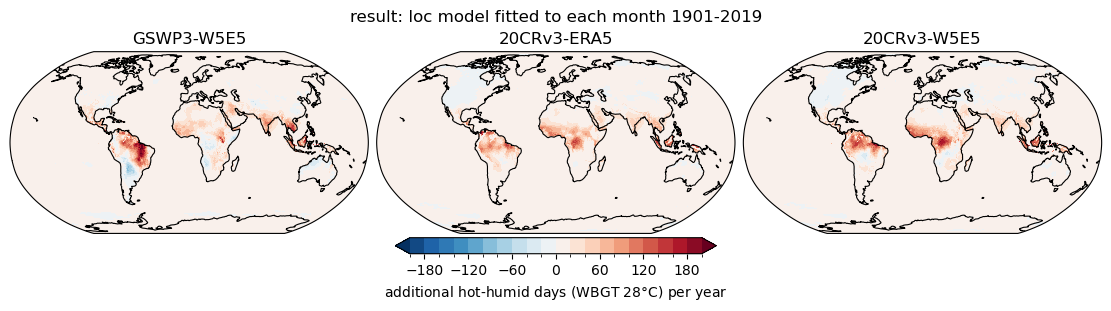

In [14]:
da = da_nAHD_obs_ll

proj = ccrs.Robinson()
crs = ccrs.PlateCarree()

# make figure object
fig, axes = plt.subplots(1,3, figsize=(11,3), subplot_kw={'projection': proj},  layout='constrained')

vmax = 200

for i in range(3):
    data_plot = da.isel(dataset=i) 
    ax=axes[i]
    plot = data_plot.plot( vmax=vmax, vmin=-vmax, cmap='RdBu_r', transform=crs, levels=21, extend='both', add_colorbar=False, ax=ax)
    ax.coastlines(color='black', linewidth=0.8)
    #ax.set_facecolor('#f0f0f0')
    ax.set_title(f'{data_plot.dataset.values}');
    
cbar_lab = 'additional hot-humid days (WBGT 28$\degree$C) per year' # try to get TeX interpreter 'less likely $\leftarrow$ PR $\rightarrow$ more likely' #'PR' # add more/less likely arrow 
cbar = fig.colorbar(plot,  extend='both', ax=axes,  location='bottom',shrink=1.5,fraction= 0.08,  pad= 0.02) #, fraction= 0.045, pad= 0.04) #location='bottom' 
cbar.set_label(label=cbar_lab) 
    
fig.suptitle('result: loc model fitted to each month 1901-2019');



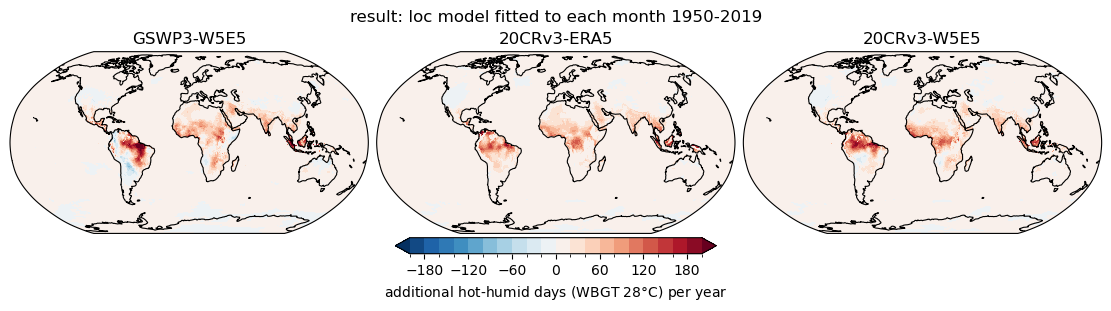

In [15]:
da = da_nAHD_obs_ls

proj = ccrs.Robinson()
crs = ccrs.PlateCarree()

# make figure object
fig, axes = plt.subplots(1,3, figsize=(11,3), subplot_kw={'projection': proj},  layout='constrained')

vmax = 200

for i in range(3):
    data_plot = da.isel(dataset=i) 
    ax=axes[i]
    plot = data_plot.plot( vmax=vmax, vmin=-vmax, cmap='RdBu_r', transform=crs, levels=21, extend='both', add_colorbar=False, ax=ax)
    ax.coastlines(color='black', linewidth=0.8)
    #ax.set_facecolor('#f0f0f0')
    ax.set_title(f'{data_plot.dataset.values}');
    
cbar_lab = 'additional hot-humid days (WBGT 28$\degree$C) per year' # try to get TeX interpreter 'less likely $\leftarrow$ PR $\rightarrow$ more likely' #'PR' # add more/less likely arrow 
cbar = fig.colorbar(plot,  extend='both', ax=axes,  location='bottom',shrink=1.5,fraction= 0.08,  pad= 0.02) #, fraction= 0.045, pad= 0.04) #location='bottom' 
cbar.set_label(label=cbar_lab) 
    
fig.suptitle('result: loc model fitted to each month 1950-2019');



## Difference due to time period

This makes a relatively large difference. 

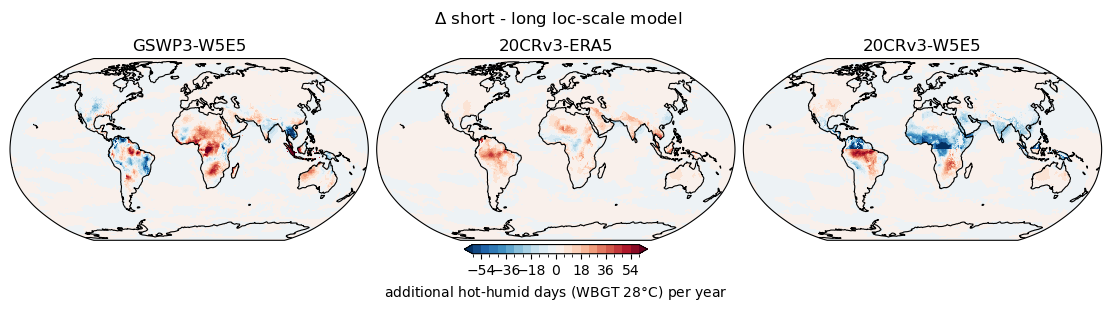

In [38]:
da =  da_nAHD_obs_lss - da_nAHD_obs_lsl

proj = ccrs.Robinson()
crs = ccrs.PlateCarree()

# make figure object
fig, axes = plt.subplots(1,3, figsize=(11,3), subplot_kw={'projection': proj},  layout='constrained')

vmax = 60

for i in range(3):
    data_plot = da.isel(dataset=i) 
    ax=axes[i]
    plot = data_plot.plot( vmax=vmax, vmin=-vmax, cmap='RdBu_r', transform=crs, levels=21, extend='both', add_colorbar=False, ax=ax)
    ax.coastlines(color='black', linewidth=0.8)
    #ax.set_facecolor('#f0f0f0')
    ax.set_title(f'{data_plot.dataset.values}');
    
cbar_lab = 'additional hot-humid days (WBGT 28$\degree$C) per year' # try to get TeX interpreter 'less likely $\leftarrow$ PR $\rightarrow$ more likely' #'PR' # add more/less likely arrow 
cbar = fig.colorbar(plot,  extend='both', ax=axes,  location='bottom',shrink=0.3,fraction= 0.045,  pad= 0.02) #, fraction= 0.045, pad= 0.04) #location='bottom' 
cbar.set_label(label=cbar_lab) 
    
fig.suptitle(' $\Delta$ short - long loc-scale model');



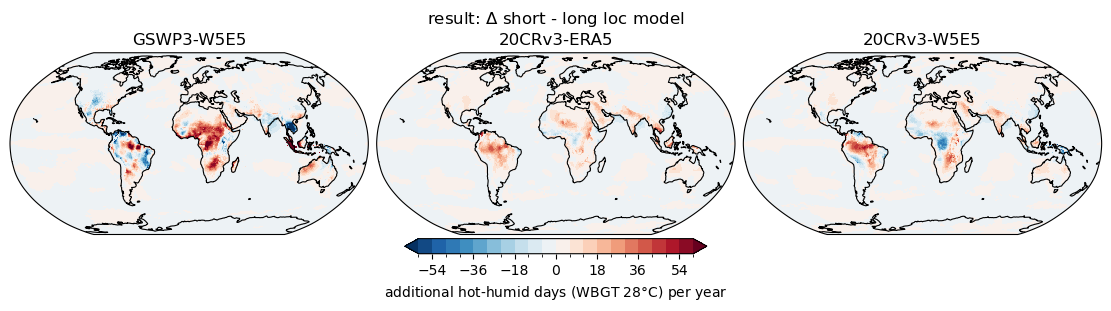

In [35]:
da = da_nAHD_obs_ls - da_nAHD_obs_ll

# loc short - loc long 

proj = ccrs.Robinson()
crs = ccrs.PlateCarree()

# make figure object
fig, axes = plt.subplots(1,3, figsize=(11,3), subplot_kw={'projection': proj},  layout='constrained')

vmax = 60

for i in range(3):
    data_plot = da.isel(dataset=i) 
    ax=axes[i]
    plot = data_plot.plot( vmax=vmax, vmin=-vmax, cmap='RdBu_r', transform=crs, levels=21, extend='both', add_colorbar=False, ax=ax)
    ax.coastlines(color='black', linewidth=0.8)
    #ax.set_facecolor('#f0f0f0')
    ax.set_title(f'{data_plot.dataset.values}');
    
cbar_lab = 'additional hot-humid days (WBGT 28$\degree$C) per year' # try to get TeX interpreter 'less likely $\leftarrow$ PR $\rightarrow$ more likely' #'PR' # add more/less likely arrow 
cbar = fig.colorbar(plot,  extend='both', ax=axes,  location='bottom',shrink=1.5,fraction= 0.08,  pad= 0.02) #, fraction= 0.045, pad= 0.04) #location='bottom' 
cbar.set_label(label=cbar_lab) 
    
fig.suptitle('result: $\Delta$ short - long loc model');



**Blue means short model sees less days than long, red means short model sees more days than long.**

Biggest difference is in GSWP3-W5E5, in both cases. (and instability in 20crv-w5e5). Similar patterns (except for c where weird instability in loc-scale model).

(a) short model sees more days in Africa in both models (note, change of sign in Congo rainforest based on period, - trend in long model, + trend in short model - could this be due to a drying ??? Less humidity ?? ). India short model sees less days. 

In (b-c) less bias. In India short model sees more days. and also over some of Amazon. In West-Central Africa (Congo rainforest?) short model sees less days. 

Ideas 
* Possibly non-stationarity better modelled as non-linear? Humidity rises non-linearly
* Look separately at trend in temperature and humidity? In regions separate out drivers of changes in humid heat stress? Scatterplot in T-qs space of days above a threshold separated in time
* Or fit non-stationary model separately to humidity and T

## Difference due to stat model

This makes a relatively small difference, at least in the loc-only model. In the loc-scale (c) something weird is happening. 

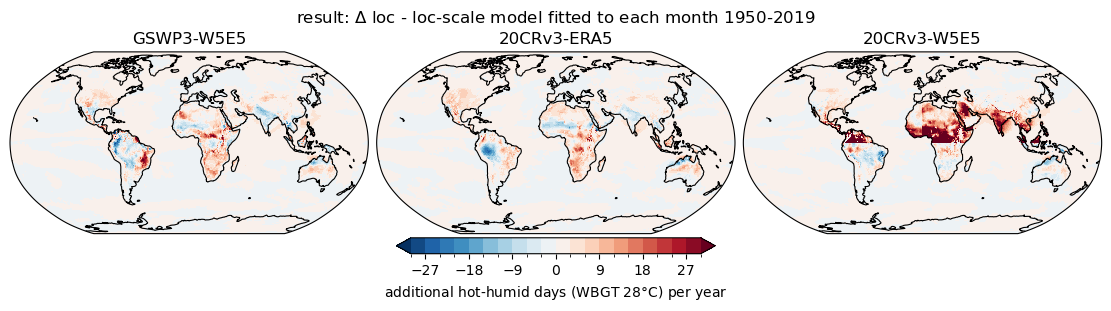

In [33]:
da = da_nAHD_obs_ls - da_nAHD_obs_lss

proj = ccrs.Robinson()
crs = ccrs.PlateCarree()

# make figure object
fig, axes = plt.subplots(1,3, figsize=(11,3), subplot_kw={'projection': proj},  layout='constrained')

vmax = 30

for i in range(3):
    data_plot = da.isel(dataset=i) 
    ax=axes[i]
    plot = data_plot.plot( vmax=vmax, vmin=-vmax, cmap='RdBu_r', transform=crs, levels=21, extend='both', add_colorbar=False, ax=ax)
    ax.coastlines(color='black', linewidth=0.8)
    #ax.set_facecolor('#f0f0f0')
    ax.set_title(f'{data_plot.dataset.values}');
    
cbar_lab = 'additional hot-humid days (WBGT 28$\degree$C) per year' # try to get TeX interpreter 'less likely $\leftarrow$ PR $\rightarrow$ more likely' #'PR' # add more/less likely arrow 
cbar = fig.colorbar(plot,  extend='both', ax=axes,  location='bottom',shrink=1.5,fraction= 0.08,  pad= 0.02) #, fraction= 0.045, pad= 0.04) #location='bottom' 
cbar.set_label(label=cbar_lab) 
    
fig.suptitle('result: $\Delta$ loc - loc-scale model fitted to each month 1950-2019');



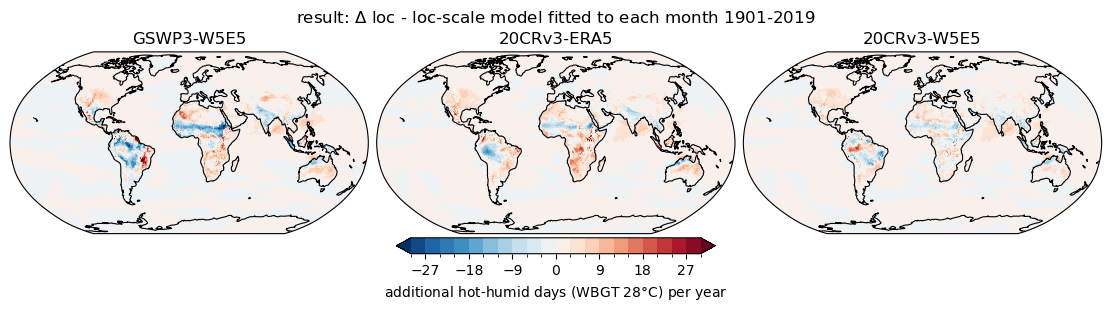

In [29]:
da = da_nAHD_obs_ll - da_nAHD_obs_lsl

proj = ccrs.Robinson()
crs = ccrs.PlateCarree()

# make figure object
fig, axes = plt.subplots(1,3, figsize=(11,3), subplot_kw={'projection': proj},  layout='constrained')

vmax = 30

for i in range(3):
    data_plot = da.isel(dataset=i) 
    ax=axes[i]
    plot = data_plot.plot( vmax=vmax, vmin=-vmax, cmap='RdBu_r', transform=crs, levels=21, extend='both', add_colorbar=False, ax=ax)
    ax.coastlines(color='black', linewidth=0.8)
    #ax.set_facecolor('#f0f0f0')
    ax.set_title(f'{data_plot.dataset.values}');
    
cbar_lab = 'additional hot-humid days (WBGT 28$\degree$C) per year' # try to get TeX interpreter 'less likely $\leftarrow$ PR $\rightarrow$ more likely' #'PR' # add more/less likely arrow 
cbar = fig.colorbar(plot,  extend='both', ax=axes,  location='bottom',shrink=1.5,fraction= 0.08,  pad= 0.02) #, fraction= 0.045, pad= 0.04) #location='bottom' 
cbar.set_label(label=cbar_lab) 
    
fig.suptitle('result: $\Delta$ loc - loc-scale model fitted to each month 1901-2019');



### Loc - loc-scale model doesn't make a huge difference (30 days colorbar range). 

Where blue, loc model gives less days, where red loc model gives more days. 

Blue areas: notably India, where a change in variance suggests more days crossing WBGT. And parts of equatorial Africa/Amazon.

### On the other hand, time period does make a difference. 


## Look at result per month  

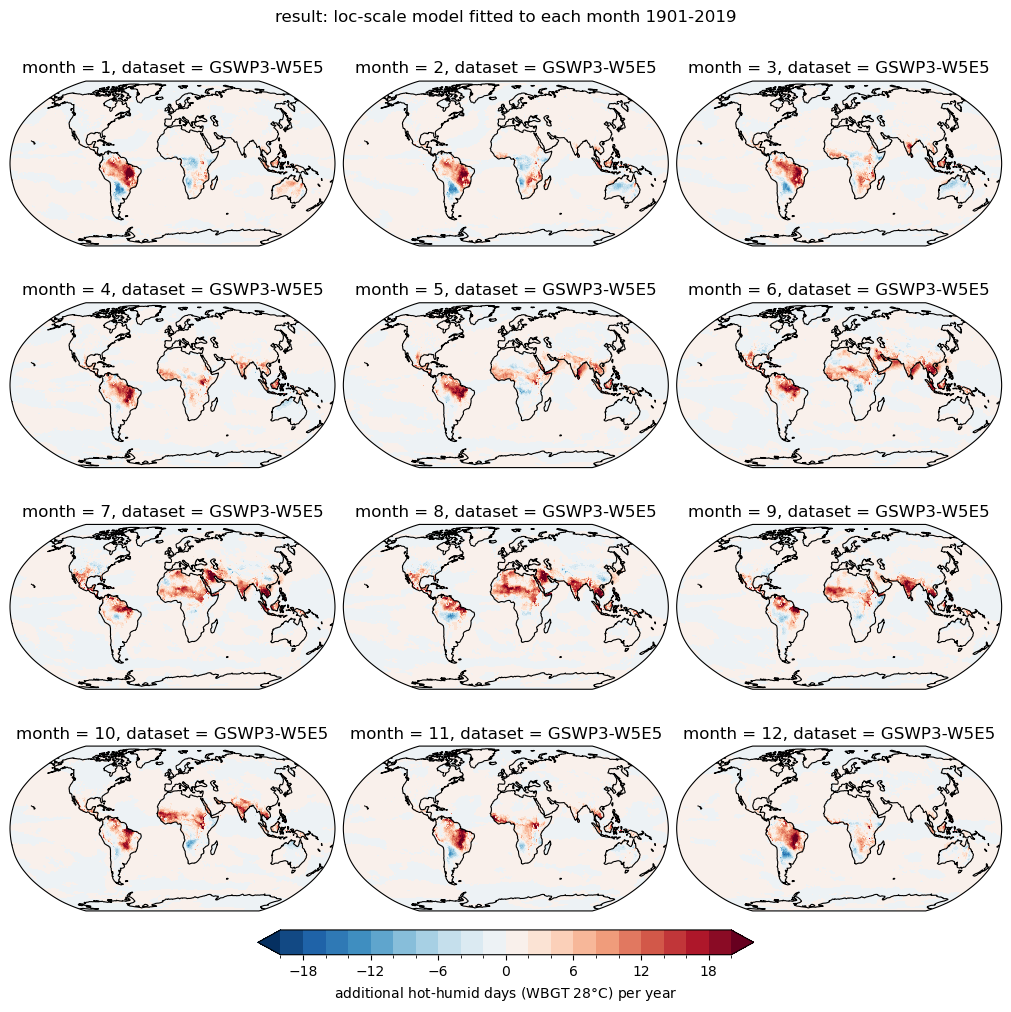

In [19]:

da = da_nAHD_mo_lsl.isel(dataset=0)

proj = ccrs.Robinson()
crs = ccrs.PlateCarree()

# make figure object
fig, axes = plt.subplots(4,3, figsize=(10,10), subplot_kw={'projection': proj},  layout='constrained')
axes=axes.flatten()

vmax = 20

for i in range(12):
    data_plot = da.isel(month=i)
    ax=axes[i]
    plot = data_plot.plot( vmax=vmax, vmin=-vmax, cmap='RdBu_r', transform=crs, levels=21, extend='both', add_colorbar=False, ax=ax)
    ax.coastlines(color='black', linewidth=0.8)
    #ax.set_facecolor('#f0f0f0')
    #ax.set_title(f'{data_plot.dataset.values}');
    
cbar_lab = 'additional hot-humid days (WBGT 28$\degree$C) per year' # try to get TeX interpreter 'less likely $\leftarrow$ PR $\rightarrow$ more likely' #'PR' # add more/less likely arrow 
cbar = fig.colorbar(plot,  extend='both', ax=axes,  location='bottom',shrink=.5,fraction= 0.08,  pad= 0.02) #, fraction= 0.045, pad= 0.04) #location='bottom' 
cbar.set_label(label=cbar_lab) 
    
fig.suptitle('result: loc-scale model fitted to each month 1901-2019');



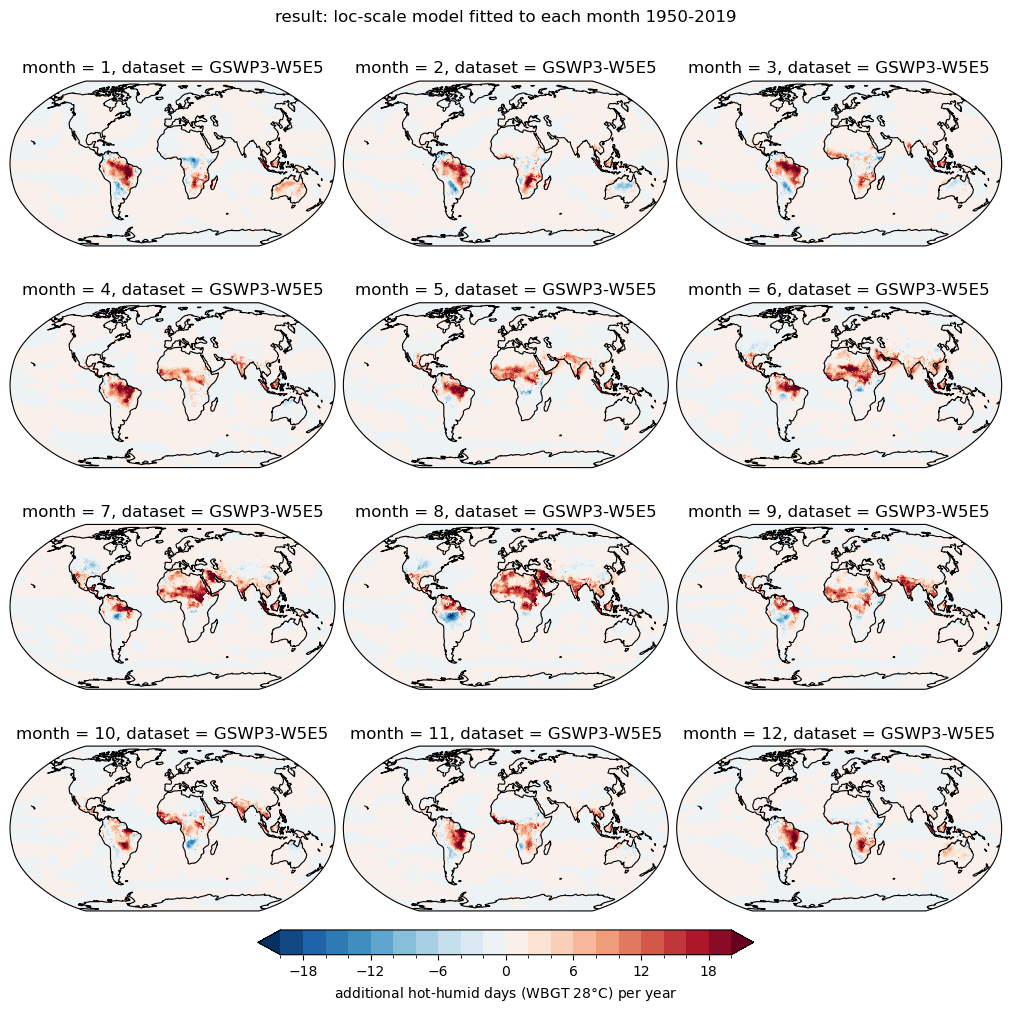

In [20]:

da = da_nAHD_mo_lss.isel(dataset=0)

proj = ccrs.Robinson()
crs = ccrs.PlateCarree()

# make figure object
fig, axes = plt.subplots(4,3, figsize=(10,10), subplot_kw={'projection': proj},  layout='constrained')
axes=axes.flatten()

vmax = 20

for i in range(12):
    data_plot = da.isel(month=i)
    ax=axes[i]
    plot = data_plot.plot( vmax=vmax, vmin=-vmax, cmap='RdBu_r', transform=crs, levels=21, extend='both', add_colorbar=False, ax=ax)
    ax.coastlines(color='black', linewidth=0.8)
    #ax.set_facecolor('#f0f0f0')
    #ax.set_title(f'{data_plot.dataset.values}');
    
cbar_lab = 'additional hot-humid days (WBGT 28$\degree$C) per year' # try to get TeX interpreter 'less likely $\leftarrow$ PR $\rightarrow$ more likely' #'PR' # add more/less likely arrow 
cbar = fig.colorbar(plot,  extend='both', ax=axes,  location='bottom',shrink=.5,fraction= 0.08,  pad= 0.02) #, fraction= 0.045, pad= 0.04) #location='bottom' 
cbar.set_label(label=cbar_lab) 
    
fig.suptitle('result: loc-scale model fitted to each month 1950-2019');



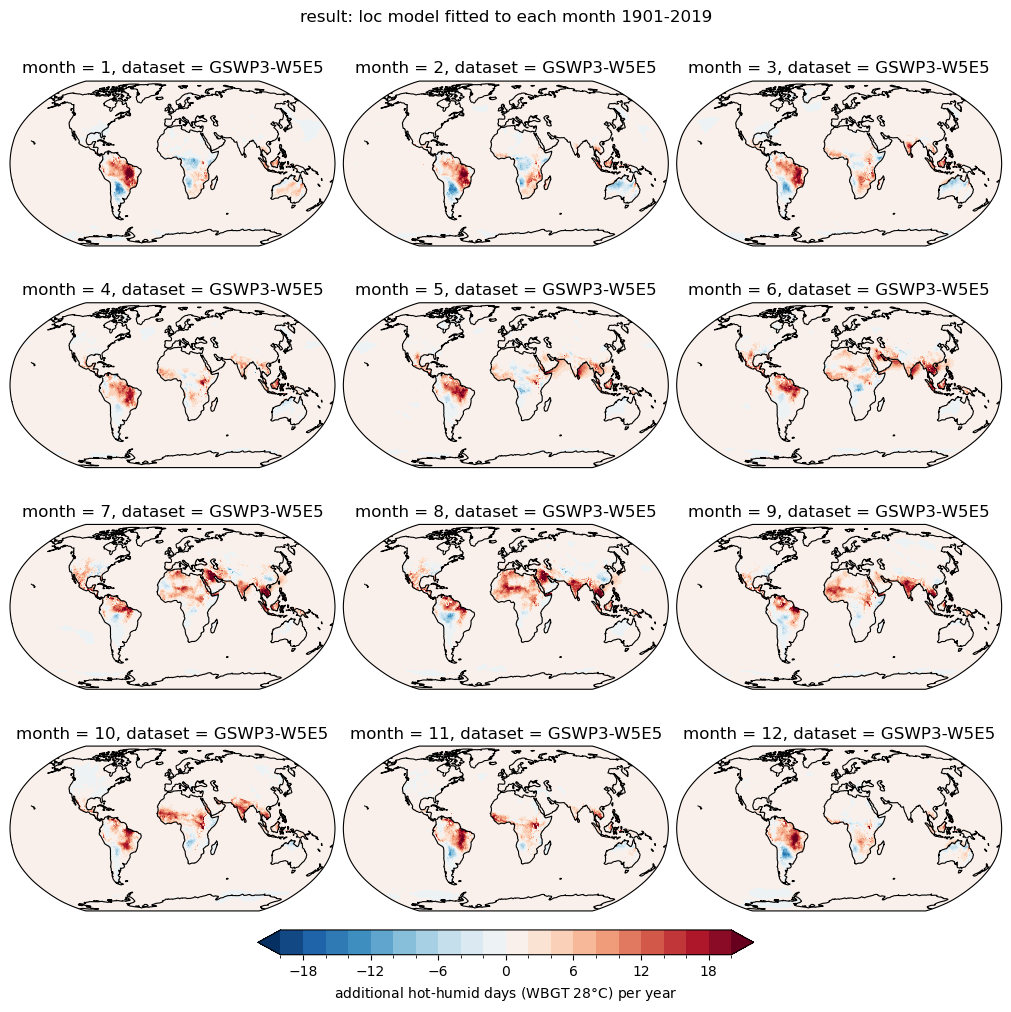

In [21]:

da = da_nAHD_mo_ll.isel(dataset=0)

proj = ccrs.Robinson()
crs = ccrs.PlateCarree()

# make figure object
fig, axes = plt.subplots(4,3, figsize=(10,10), subplot_kw={'projection': proj},  layout='constrained')
axes=axes.flatten()

vmax = 20

for i in range(12):
    data_plot = da.isel(month=i)
    ax=axes[i]
    plot = data_plot.plot( vmax=vmax, vmin=-vmax, cmap='RdBu_r', transform=crs, levels=21, extend='both', add_colorbar=False, ax=ax)
    ax.coastlines(color='black', linewidth=0.8)
    #ax.set_facecolor('#f0f0f0')
    #ax.set_title(f'{data_plot.dataset.values}');
    
cbar_lab = 'additional hot-humid days (WBGT 28$\degree$C) per year' # try to get TeX interpreter 'less likely $\leftarrow$ PR $\rightarrow$ more likely' #'PR' # add more/less likely arrow 
cbar = fig.colorbar(plot,  extend='both', ax=axes,  location='bottom',shrink=.5,fraction= 0.08,  pad= 0.02) #, fraction= 0.045, pad= 0.04) #location='bottom' 
cbar.set_label(label=cbar_lab) 
    
fig.suptitle('result: loc model fitted to each month 1901-2019');



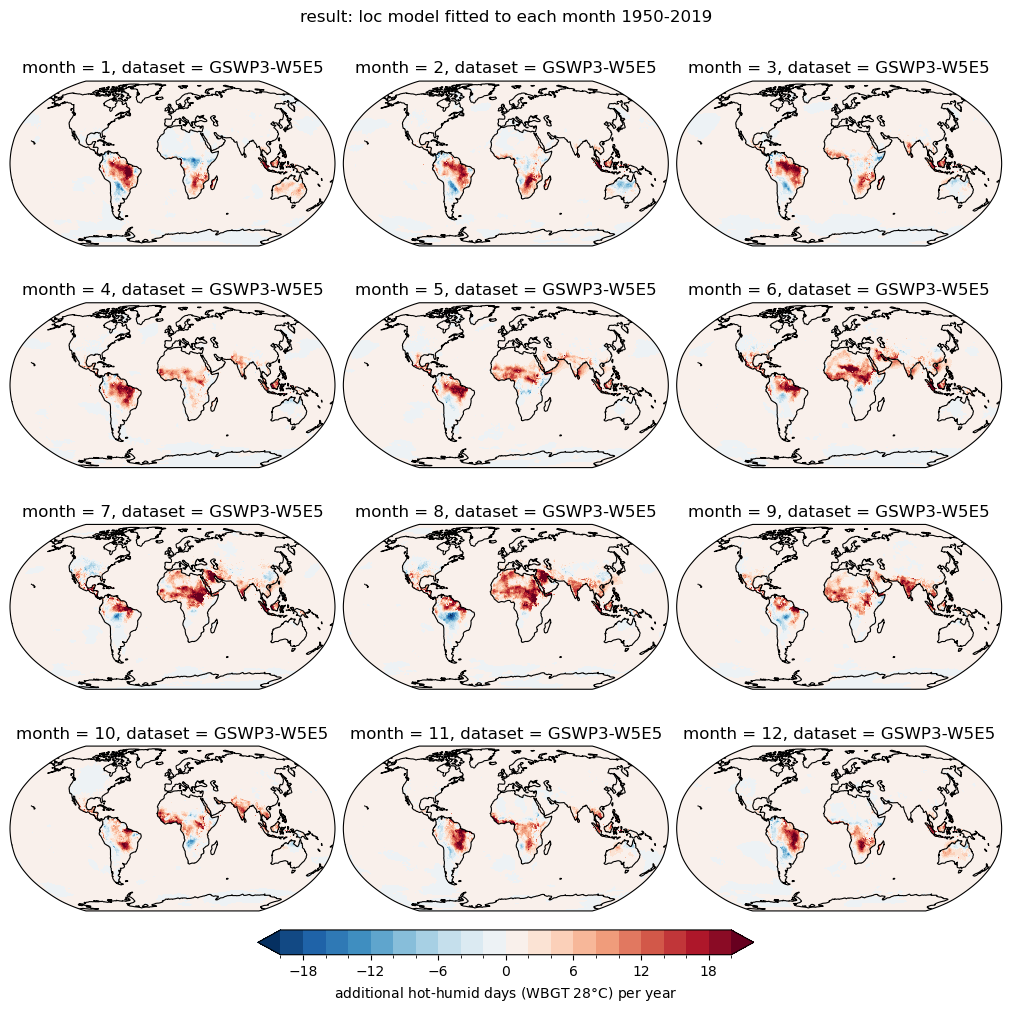

In [22]:

da = da_nAHD_mo_ls.isel(dataset=0)

proj = ccrs.Robinson()
crs = ccrs.PlateCarree()

# make figure object
fig, axes = plt.subplots(4,3, figsize=(10,10), subplot_kw={'projection': proj},  layout='constrained')
axes=axes.flatten()

vmax = 20

for i in range(12):
    data_plot = da.isel(month=i)
    ax=axes[i]
    plot = data_plot.plot( vmax=vmax, vmin=-vmax, cmap='RdBu_r', transform=crs, levels=21, extend='both', add_colorbar=False, ax=ax)
    ax.coastlines(color='black', linewidth=0.8)
    #ax.set_facecolor('#f0f0f0')
    #ax.set_title(f'{data_plot.dataset.values}');
    
cbar_lab = 'additional hot-humid days (WBGT 28$\degree$C) per year' # try to get TeX interpreter 'less likely $\leftarrow$ PR $\rightarrow$ more likely' #'PR' # add more/less likely arrow 
cbar = fig.colorbar(plot,  extend='both', ax=axes,  location='bottom',shrink=.5,fraction= 0.08,  pad= 0.02) #, fraction= 0.045, pad= 0.04) #location='bottom' 
cbar.set_label(label=cbar_lab) 
    
fig.suptitle('result: loc model fitted to each month 1950-2019');



## other datasets

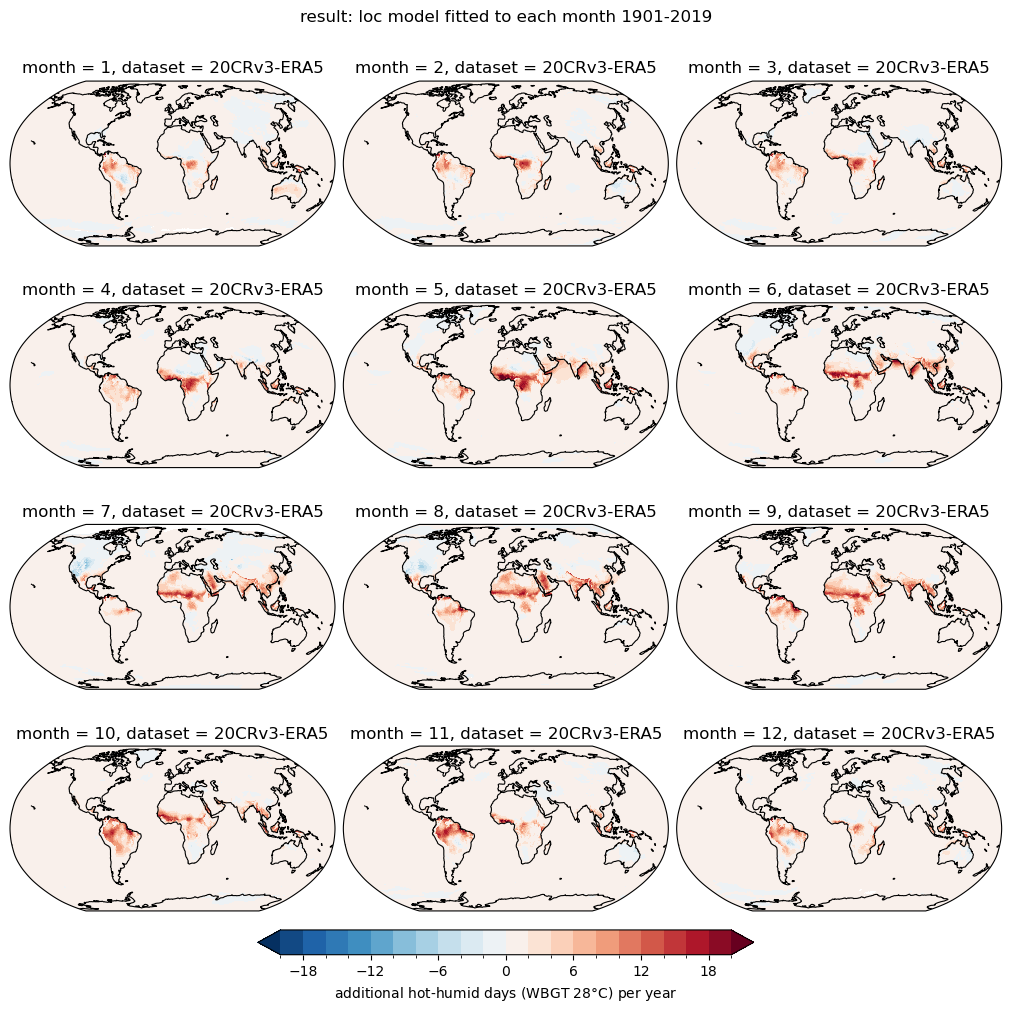

In [56]:

da = da_nAHD_mo_ll.isel(dataset=1)

proj = ccrs.Robinson()
crs = ccrs.PlateCarree()

# make figure object
fig, axes = plt.subplots(4,3, figsize=(10,10), subplot_kw={'projection': proj},  layout='constrained')
axes=axes.flatten()

vmax = 20

for i in range(12):
    data_plot = da.isel(month=i)
    ax=axes[i]
    plot = data_plot.where(data_plot != 0).plot( vmax=vmax, vmin=-vmax, cmap='RdBu_r', transform=crs, levels=21, extend='both', add_colorbar=False, ax=ax)
    ax.coastlines(color='black', linewidth=0.8)
    #ax.set_facecolor('#f0f0f0')
    #ax.set_title(f'{data_plot.dataset.values}');
    
cbar_lab = 'additional hot-humid days (WBGT 28$\degree$C) per year' # try to get TeX interpreter 'less likely $\leftarrow$ PR $\rightarrow$ more likely' #'PR' # add more/less likely arrow 
cbar = fig.colorbar(plot,  extend='both', ax=axes,  location='bottom',shrink=.5,fraction= 0.08,  pad= 0.02) #, fraction= 0.045, pad= 0.04) #location='bottom' 
cbar.set_label(label=cbar_lab) 
    
fig.suptitle('result: loc model fitted to each month 1901-2019');



## Look at params of loc models

In [50]:
landmask = get_mask()

Text(0.5, 0.98, 'params 1901-2019')

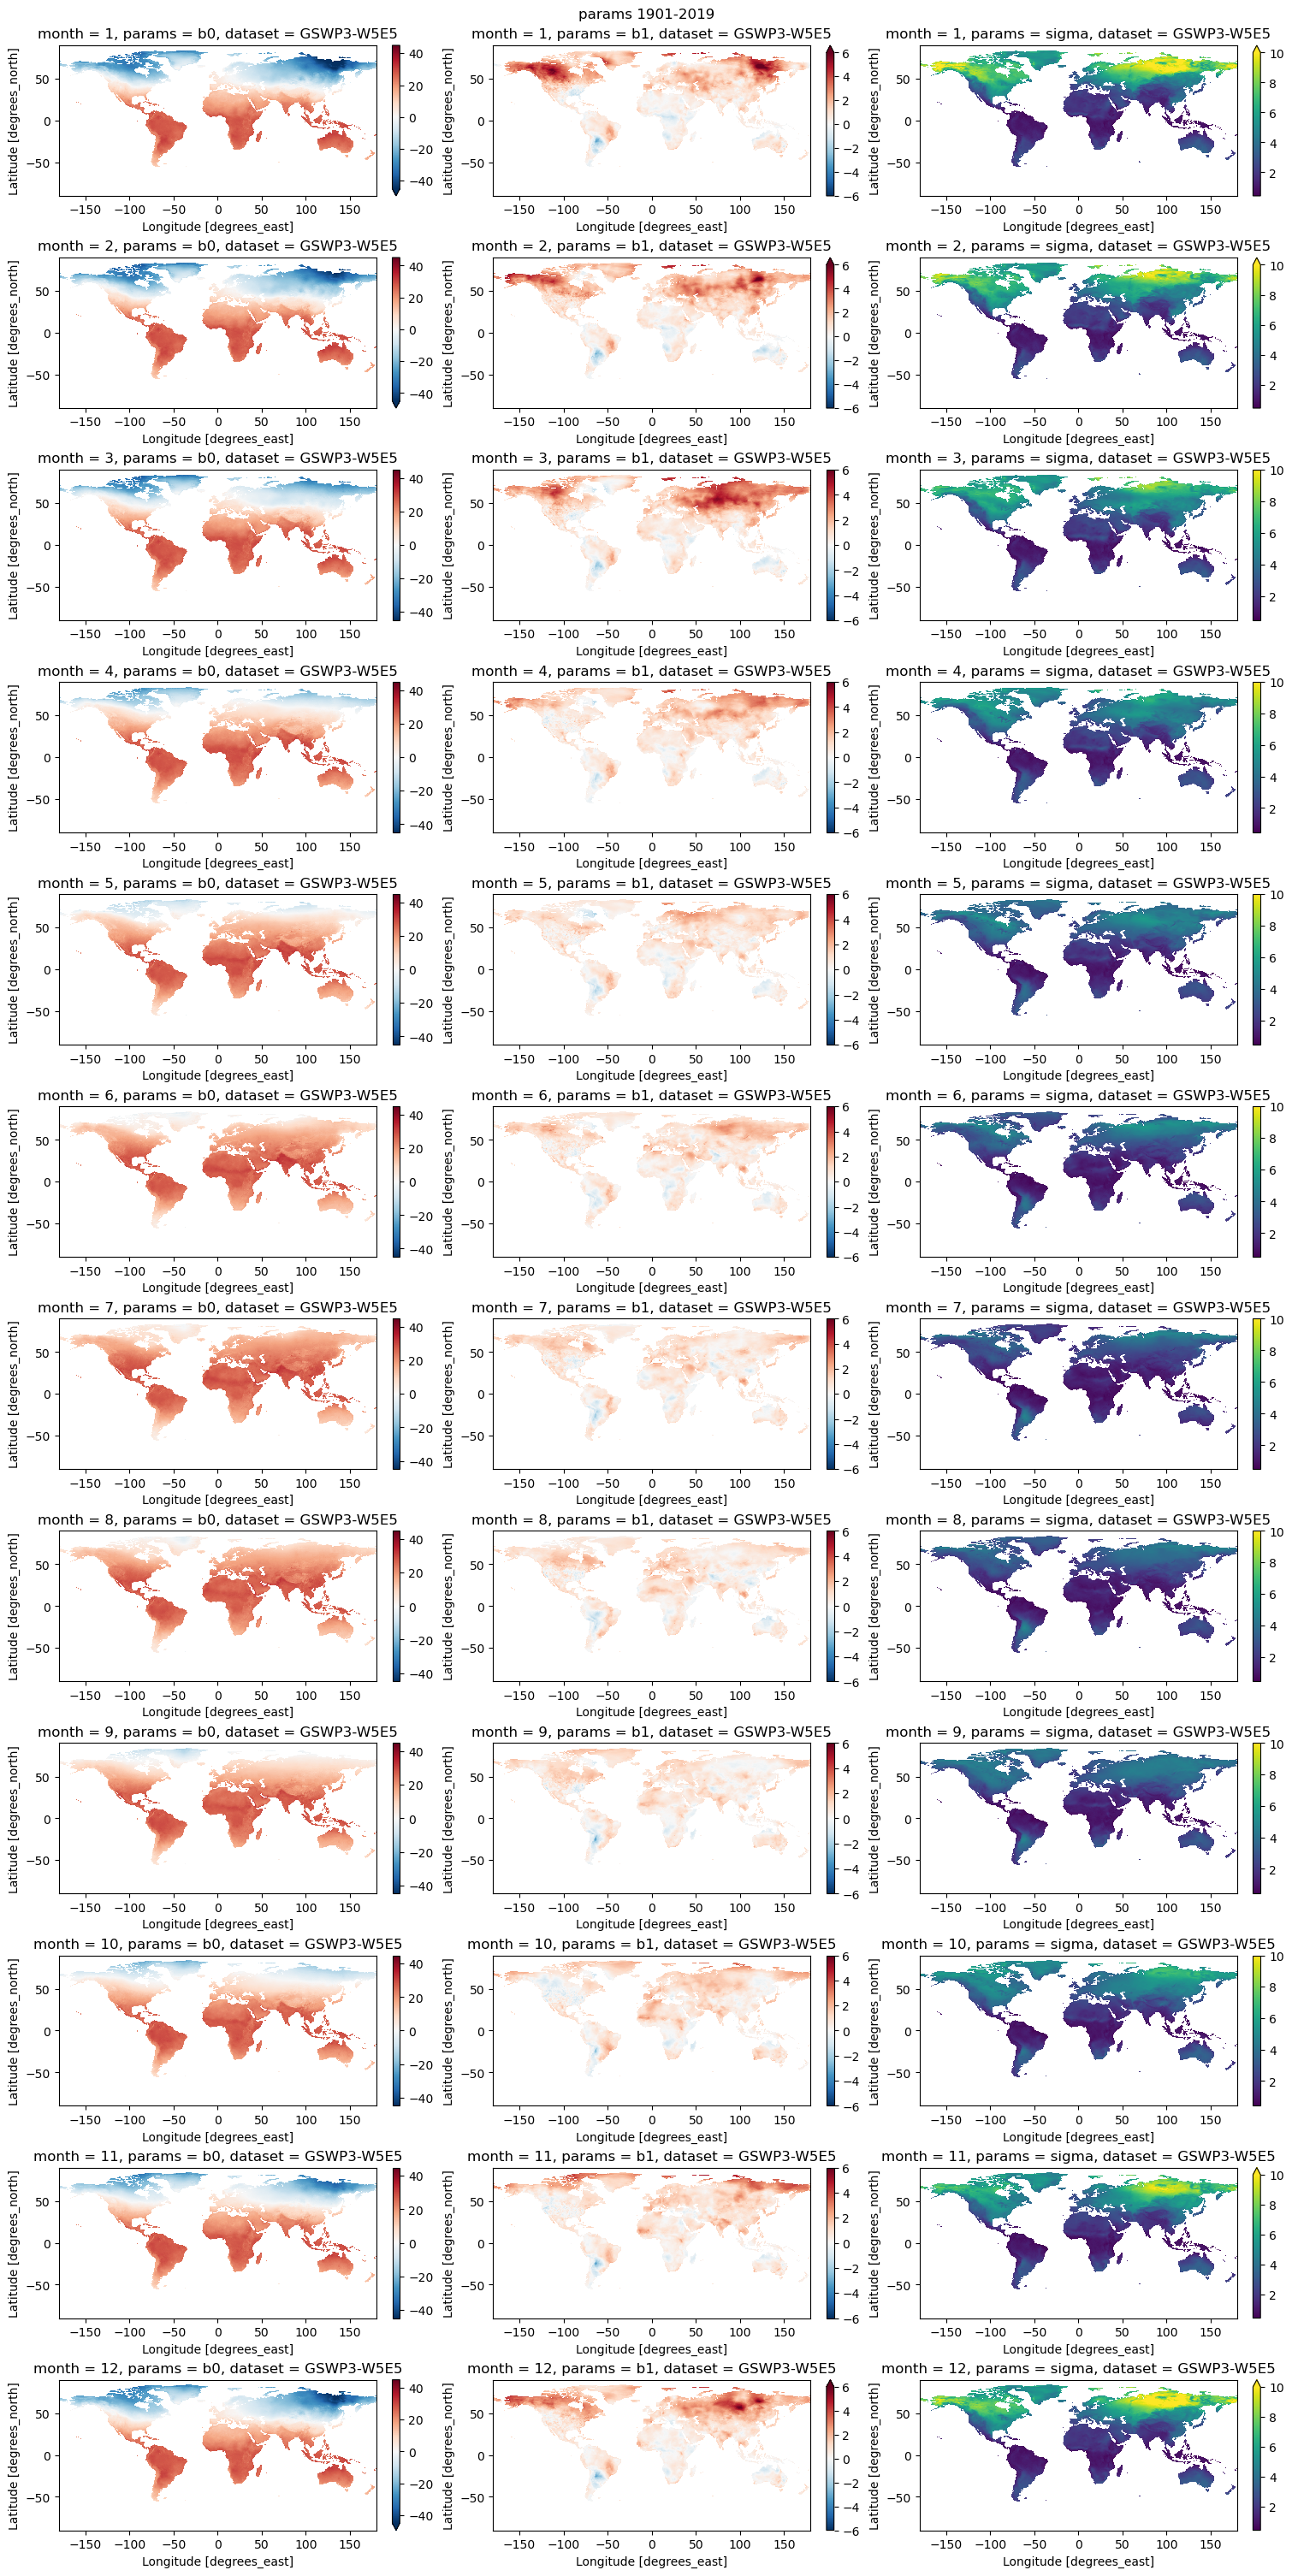

In [58]:
fig, axes = plt.subplots(12,3,figsize=(15,30), layout='constrained')

axes=axes.flatten()

da_params = da_params_ll.isel(dataset=0) * landmask

j=0
#cmap='
for i in range(1,13):
    #print(j)
    da_params.sel(month=i,params='b0').plot(ax=axes[j],vmax=45)
    da_params.sel(month=i,params='b1').plot(ax=axes[j+1], vmax=6)
    da_params.sel(month=i,params='sigma').plot(ax=axes[j+2], vmax=10)
    j+=3

fig.suptitle('params 1901-2019')

Text(0.5, 0.98, 'params 1950-2019')

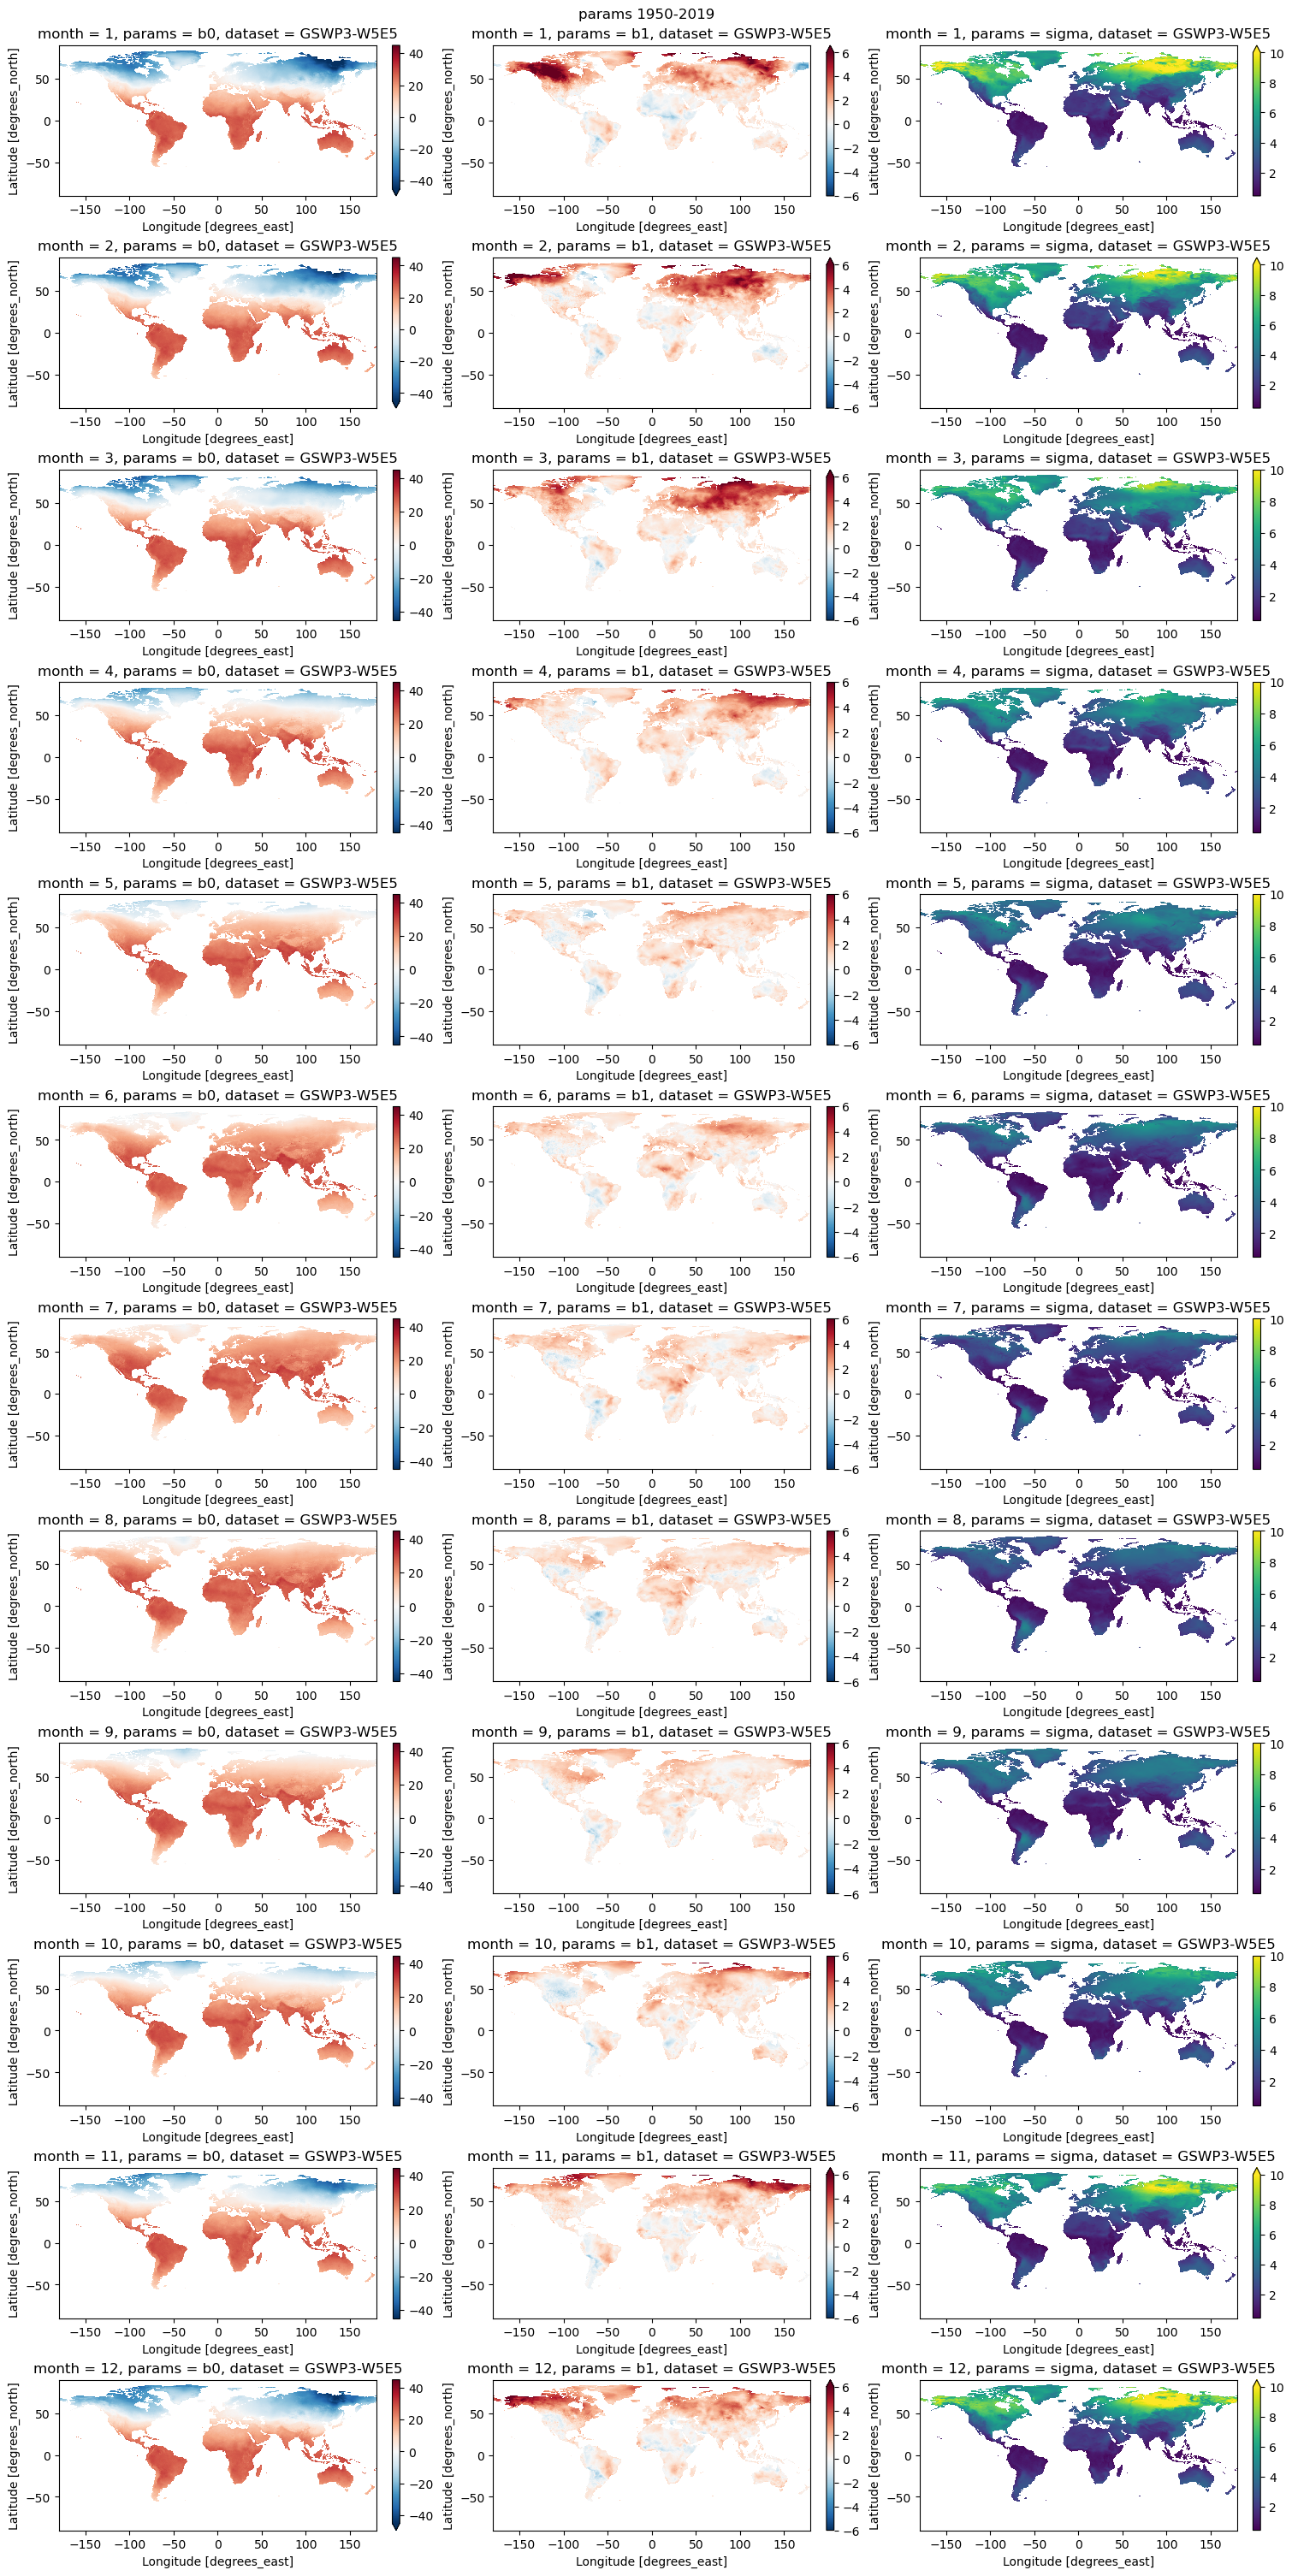

In [59]:
fig, axes = plt.subplots(12,3,figsize=(15,30), layout='constrained')

axes=axes.flatten()

da_params = da_params_ls.isel(dataset=0) * landmask

j=0
#cmap='
for i in range(1,13):
    #print(j)
    da_params.sel(month=i,params='b0').plot(ax=axes[j],vmax=45)
    da_params.sel(month=i,params='b1').plot(ax=axes[j+1], vmax=6)
    da_params.sel(month=i,params='sigma').plot(ax=axes[j+2], vmax=10)
    j+=3

fig.suptitle('params 1950-2019')